<a href="https://colab.research.google.com/github/jemoce/DL-with-PyTorch/blob/main/02_Logistic_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
from typing import Callable
from datetime import datetime
import numpy as np
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (confusion_matrix, recall_score, precision_score, 
                             accuracy_score, roc_curve, precision_recall_curve, 
                             auc)
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from torch.utils.tensorboard.writer import SummaryWriter

%matplotlib inline

In [14]:
class LogisticRegressor():
  def __init__(self, model: nn.Module, optim: optim.Optimizer, 
               loss_fn: Callable) -> None:
    """
    Args:
    model (nn.Module): model to use during the training and to make predictions.
    optim (optim.Optimizer): optimizer to optimize the model during training.
    loss_fn (Callable): function to calculate model´s losses.

    Returns: None
    """
    self.device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # Model, optimizer and loss function
    self.model = model.to(self.device)
    self.optim = optim
    self.loss_fn = loss_fn

    # Data
    self.train_dl: DataLoader = None
    self.val_dl: DataLoader = None

    # Training functions
    self.train_step = self._make_train_step()
    self.val_step = self._make_val_step()

    # Epoch and losses
    self.act_epoch = 0
    self.train_losses = []
    self.val_losses = []

    # Tensorboard
    self.writer = None

  def set_dataloaders(self, train: DataLoader, 
                      validation: DataLoader=None) -> None:
    """
    Assign the training and validation (optional) to train the model. 
    Args:
    train (DataLoader): DataLoader with the training data.
    validation (DataLoader): DataLoader with validation data. If not proviced
      the system will not validate the model during training.

    Returns: None.
    """
    self.train_dl = train
    self.val_dl = validation

  def _make_train_step(self) -> Callable:
    """
    Returns the function used for training the model.

    Returns: Callable function.
    """
    def step(x: torch.Tensor, y: torch.Tensor) -> float:
      """
      Trains the model with x (inputs) and y (labels) data.

      Returns: training loss.
      """
      self.model.train()
      y_hat = self.model(x)
      loss = self.loss_fn(y_hat, y)
      loss.backward()
      self.optim.step()
      self.optim.zero_grad()
      return loss.item()
    return step

  def _make_val_step(self) -> Callable:
    """
    Returns the function used to validate the model.

    Returns: Callable function.
    """
    def step(x: torch.Tensor, y: torch.Tensor) -> float:
      """
      Evaluates the model and returns the loss of the model.

      Returns: evaluation loss.
      """
      self.model.eval()
      y_hat = self.model(x)
      loss = self.loss_fn(y_hat, y)
      return loss.item()
    return step    

  def _mini_batch_step(self, validation: bool = False) -> float:
    """
    Performs the training or validation (depending on validation input variable)
    of the model and returns the loss of the step.
    Args:
    validation (bool): True to use validation data. False to use training data.

    Returns: loss.
    """
    step = self.val_step if validation else self.train_step
    data_loader = self.val_dl if validation else self.train_dl
    if data_loader is None:
      return None

    losses = []
    for x, y in data_loader:
      x = x.to(self.device)
      y = y.to(self.device)

      loss = step(x,y)
      losses.append(loss)

    return np.mean(losses)

  def set_seed(self, n=42) -> None:
    """
    Sets the seed for random numbers.
    Args:
    n: seed.

    Returns: None.
    """
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    torch.manual_seed(n)
    np.random.seed(n)

  def train(self, epochs: int) -> None:
    """
    Train the model.
    Args:
    epochs (int): number of epochs to train the model.

    Returns: None.
    """
    self.model.train()
    self.set_seed()
    for epoch in range(epochs):
      train_loss = self._mini_batch_step()
      self.train_losses.append(train_loss)

      with torch.no_grad():
        val_loss = self._mini_batch_step(validation=True)
        self.val_losses.append(val_loss)

      if self.writer:
        scalars = {'Train':train_loss}
        if val_loss is not None:
          scalars['Validation'] = val_loss
        self.writer.add_scalars(main_tag='loss',
                                tag_scalar_dict=scalars,
                                global_step=self.act_epoch)
      
      self.act_epoch += 1

    if self.writer:
      self.writer.flush()

    self.model.eval()

  def plot_losses(self) -> None:
    """
    Plots the losses of the model. If validation dataloader was previously 
    assigned using set_dataloaders method then the plot will contain validation
    losses.

    Returns: None.
    """
    fig = plt.figure(figsize=(10,3))
    plt.plot(self.train_losses, 'b', label='Training')
    if self.val_dl:
      plt.plot(self.val_losses, 'r', label='Validation')
    plt.yscale('log')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

  def predict(self, x: np.array) -> np.array:
    """
    Returns the predictions of the model on x data.
    Args:
    x (array): input to the model.

    Returns: numpy array with the predictions.
    """
    self.model.eval()
    data = torch.as_tensor(x).float()
    predicted = self.model(data.to(self.device))
    return predicted.detach().cpu().numpy()

  def set_tensorboard(self, name: str, folder: str='logs') -> None:
    """
    Sets the folder and data´s name for the tensorboard board to show the 
    losses during the training. To load tensorboard in a notebook use
    %tensorboard --logdir logs.
    Args:
    name (str): preffix of the files where the data will be saved.
    folder (str): name of the folder where the files will be saved.

    Returns: None.
    """
    suffix = datetime.now().strftime('%Y%m%d%H%M%S')
    self.writer = SummaryWriter(log_dir=f'{folder}/{name}_{suffix}')

  def add_graph(self) -> None:
    """
    Adds the graph to the tensorboard. The tensorboards has to be already 
    configured using set_tensorboard.

    Returns: None.
    """
    if self.train_dl and self.writer:
      x,_ = next(iter(self.train_dl))
      self.writer.add_graph(self.model, x.to(self.device))

  def save_checkpoint(self, filename: str) -> None:
    """
    Saves the state of the model to a file.
    Args:
    filename (str): name of the file where the data will be saved.

    Returns: None.
    """
    checkpoint = {
        'model_state': self.model.state_dict(),
        'optimizer_state': self.optim.state_dict(),
        'epoch': self.act_epoch,
        'train_losses': self.train_losses,
        'val_losses': self.val_losses
    }
    torch.save(checkpoint, filename)

  def load_checkpoint(self, filename: str) -> None:
    """
    Loads the state of the model from a file.
    Args:
    filename (str): name of the file where the data is saved.

    Returns: None
    """
    checkpoint = torch.load(filename)
    self.model.load_state_dict(checkpoint['model_state'])
    self.optim.load_state_dict(checkpoint['optimizer_state'])
    self.act_epoch = checkpoint['epoch']
    self.train_losses = checkpoint['train_losses']
    self.val_losses = checkpoint['val_losses']

In [15]:
torch.manual_seed(42)

model = nn.Sequential()
model.add_module('linear', nn.Linear(2, 1))
model.add_module('sigmoid', nn.Sigmoid())

model_b = nn.Linear(2, 1)

optimizer = optim.SGD(model.parameters(), lr=0.1)
optimizer_b = optim.SGD(model_b.parameters(), lr=0.1)

loss_fn = nn.BCELoss()
loss_fn_b = nn.BCEWithLogitsLoss()

lreg = LogisticRegressor(model, optimizer, loss_fn)
lreg_b = LogisticRegressor(model_b, optimizer_b, loss_fn_b)

lreg.set_seed()
lreg_b.set_seed()

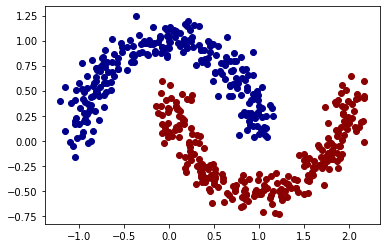

In [16]:
x_np, y_np = make_moons(500, shuffle=True, noise=0.1)

plt.scatter(x_np[y_np==0, 0], x_np[y_np==0, 1], color='darkblue')
plt.scatter(x_np[y_np==1, 0], x_np[y_np==1, 1], color='darkred')
plt.show()

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x_np, y_np,
                                                  test_size=0.2, 
                                                  random_state=42)
scaler = StandardScaler()
scaler.fit(x_train)
x_val = scaler.transform(x_val)

x_train_tensor = torch.as_tensor(x_train).float()
y_train_tensor = torch.as_tensor(y_train.reshape((-1, 1))).float()
x_val_tensor = torch.as_tensor(x_val).float()
y_val_tensor = torch.as_tensor(y_val.reshape((-1, 1))).float()

train_ds = TensorDataset(x_train_tensor, y_train_tensor)
val_ds = TensorDataset(x_val_tensor, y_val_tensor)

train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=32)

lreg.set_dataloaders(train_dl, val_dl)
lreg_b.set_dataloaders(train_dl, val_dl)

In [ ]:
lreg.train(200)
lreg_b.train(200)

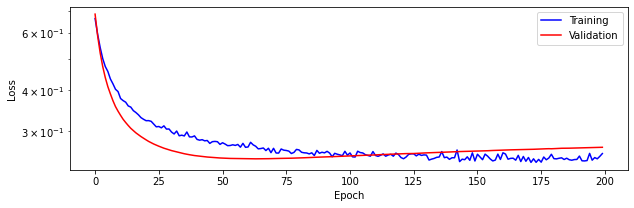

In [ ]:
lreg.plot_losses()

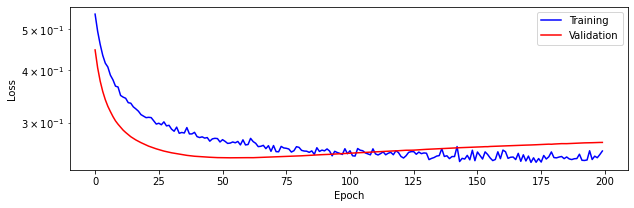

In [ ]:
lreg_b.plot_losses()

In [ ]:
model_probs = lreg.predict(x_val).reshape(-1)

model_b_logits = lreg_b.predict(x_val)
model_b_probs = torch.sigmoid(torch.as_tensor(model_b_logits).float())
model_b_probs = model_b_probs.numpy().reshape(-1)

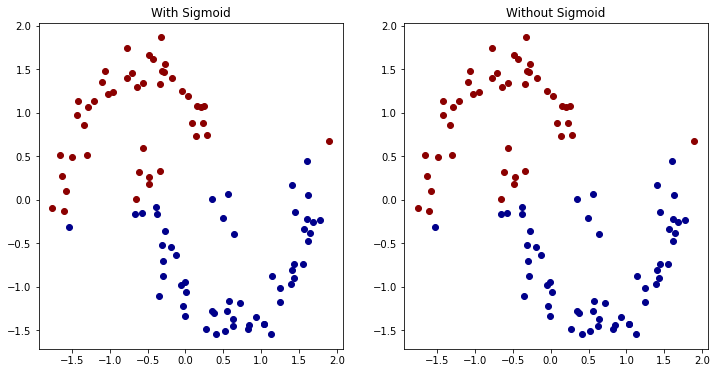

In [ ]:
true_obs = x_val[model_probs >= 0.5]
false_obs = x_val[model_probs < 0.5]

figure, axis = plt.subplots(1, 2, figsize=(12,6))
axis[0].scatter(true_obs[:, 0], true_obs[:, 1], color='darkblue')
axis[0].scatter(false_obs[:, 0], false_obs[:, 1], color='darkred')
axis[0].set_title('With Sigmoid')

true_obs = x_val[model_b_probs >= 0.5]
false_obs = x_val[model_b_probs < 0.5]

axis[1].scatter(true_obs[:, 0], true_obs[:, 1], color='darkblue')
axis[1].scatter(false_obs[:, 0], false_obs[:, 1], color='darkred')
axis[1].set_title('Without Sigmoid')

plt.show()

### Binary clasification model metrics

In [ ]:
y_hat = model_probs >= 0.5

# Confusion matrix
cm = confusion_matrix(y_val, y_hat)
print('Confusion matrix')
print(cm)

# True negative, false positive, false negative and true positive
tn, fp, fn, tp = cm.reshape(-1)

# True positive rate or recall
tpr = tp / (tp + fn)
recall = recall_score(y_val, y_hat)
print(f'tpr: {tpr} | recall: {recall}')

# False positive rate or specifity
fpr = fp / (fp + tn)
print(f'fpr: {fpr}')

# Precision
sk_prec = precision_score(y_val, y_hat)
prec = tp / (tp + fp)
print(f'Precision calculated: {prec} | sklearn: {sk_prec}')

# Accuracy
sk_accur = accuracy_score(y_val, y_hat)
accur = (tp + tn) / (tp + tn + fp + fn)
print(f'Accuracy calculated: {accur} | sklearn: {sk_accur}')

Confusion matrix
[[38  5]
 [ 7 50]]
tpr: 0.8771929824561403 | recall: 0.8771929824561403
fpr: 0.11627906976744186
Precision calculated: 0.9090909090909091 | sklearn: 0.9090909090909091
Accuracy calculated: 0.88 | sklearn: 0.88


### Graphs to compare models

Area Under the Curve: 0.8804569563443493
Area Under the Curve: 0.9281419457735248


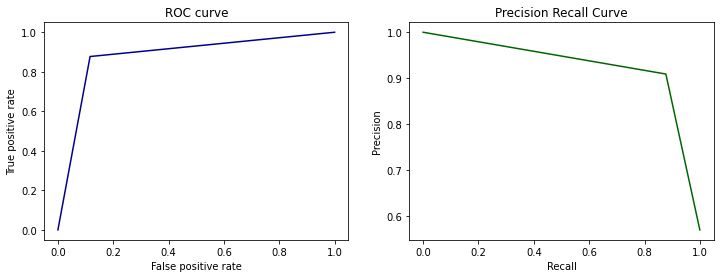

In [ ]:
fpr, tpr, _ = roc_curve(y_val, y_hat)
au_roc = auc(fpr, tpr)
print(f'Area Under the Curve: {au_roc}')

pr_precision, pr_recall, _ = precision_recall_curve(y_val, y_hat)
au_pr = auc(pr_recall, pr_precision)
print(f'Area Under the Curve: {au_pr}')

figure, axis = plt.subplots(1, 2, figsize=(12,4))

axis[0].plot(fpr, tpr, color='darkblue')
axis[0].set_xlabel('False positive rate')
axis[0].set_ylabel('True positive rate')
axis[0].set_title('ROC curve')

axis[1].plot(pr_recall, pr_precision, color='darkgreen')
axis[1].set_xlabel('Recall')
axis[1].set_ylabel('Precision')
axis[1].set_title('Precision Recall Curve')

plt.show()